In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics

In [2]:
def NormOne(a):
    return np.ones_like(a)/len(a)

## Look into inference output

Read file with inference results on validation data set and compute useful derived quantities.

In [3]:
pred = pd.read_hdf("infer_test_all2.h5",mode='a')
pred

,id,plane,wire,time,y_filter,y_semantic,y_instance,x_semantic,MIP,HIP,shower,michel,diffuse,run,subrun,event
0,880,u,438.900024,205.617004,True,MIP,-1,MIP,0.903093,-5.672994,-4.310962,-4.721311,-0.517932,6972,21,1060
1,881,u,438.600006,205.870926,True,MIP,-1,MIP,2.165558,-5.629477,-4.721538,-5.011906,-2.034383,6972,21,1060
2,882,u,438.300018,206.140656,True,MIP,-1,MIP,2.902201,-5.845088,-4.714468,-5.142314,-2.651157,6972,21,1060
3,883,u,438.000031,206.487152,True,MIP,-1,MIP,2.983333,-6.075093,-4.232587,-5.186674,-2.046385,6972,21,1060
4,884,u,437.700012,206.738083,True,MIP,-1,MIP,3.746081,-6.075973,-4.604160,-4.923613,-2.129544,6972,21,1060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25223,593,y,13.200001,213.820343,False,NaN,-1,diffuse,-0.447435,-3.193812,-3.341818,-2.067106,0.628114,6871,165,8280
25224,594,y,7.500000,232.615631,False,NaN,-1,MIP,0.605527,-3.298819,-2.933824,-2.057351,-2.134473,6871,165,8280
25225,595,y,7.200000,232.572433,False,NaN,-1,MIP,1.464549,-2.078357,-2.319567,-2.816596,-2.199179,6871,165,8280
25226,596,y,3.300000,197.251892,False,NaN,-1,diffuse,-0.431075,-3.102669,-4.278598,-1.120384,2.117097,6871,165,8280


In [4]:
print('total number of events:',len(pred.groupby(['run','subrun','event']).count()))

total number of events: 16688


In [5]:
classes=['MIP','HIP','shower','michel','diffuse']
pred['sem_label'] = pd.Categorical(pred['y_semantic']).codes
pred['sem_pred'] = pd.Categorical(pred['x_semantic']).codes
pred['x_semantic_2nd'] = pred[classes].mask(pred[classes].eq(pred[classes].max(axis=1), axis=0)).idxmax(axis=1)

In [6]:
pred['isgood'] = pred.eval('sem_label==sem_pred').astype(int)

In [7]:
pred['true_score'] = 0
pred['pred_score'] = 0
pred['pred_score_2nd'] = 0
for ctg in classes:
    pred.loc[pred['y_semantic']==ctg, 'true_score'] = pred[ctg][pred['y_semantic']==ctg]
    pred.loc[pred['x_semantic']==ctg, 'pred_score'] = pred[ctg][pred['x_semantic']==ctg]
    pred.loc[pred['x_semantic_2nd']==ctg, 'pred_score_2nd'] = pred[ctg][pred['x_semantic_2nd']==ctg]

In [8]:
pred['pred_score_p'] = pred.eval('exp(pred_score)/(exp(MIP)+exp(HIP)+exp(shower)+exp(michel)+exp(diffuse))')
pred['true_score_p'] = pred.eval('exp(true_score)/(exp(MIP)+exp(HIP)+exp(shower)+exp(michel)+exp(diffuse))')
pred

,id,plane,wire,time,y_filter,y_semantic,y_instance,x_semantic,MIP,HIP,...,event,sem_label,sem_pred,x_semantic_2nd,isgood,true_score,pred_score,pred_score_2nd,pred_score_p,true_score_p
0,880,u,438.900024,205.617004,True,MIP,-1,MIP,0.903093,-5.672994,...,1060,0,0,diffuse,1,0.903093,0.903093,-0.517932,0.798781,0.798781
1,881,u,438.600006,205.870926,True,MIP,-1,MIP,2.165558,-5.629477,...,1060,0,0,diffuse,1,2.165558,2.165558,-2.034383,0.983098,0.983098
2,882,u,438.300018,206.140656,True,MIP,-1,MIP,2.902201,-5.845088,...,1060,0,0,diffuse,1,2.902201,2.902201,-2.651157,0.995177,0.995177
3,883,u,438.000031,206.487152,True,MIP,-1,MIP,2.983333,-6.075093,...,1060,0,0,diffuse,1,2.983333,2.983333,-2.046385,0.992383,0.992383
4,884,u,437.700012,206.738083,True,MIP,-1,MIP,3.746081,-6.075973,...,1060,0,0,diffuse,1,3.746081,3.746081,-2.129544,0.996741,0.996741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25223,593,y,13.200001,213.820343,False,NaN,-1,diffuse,-0.447435,-3.193812,...,8280,-1,4,MIP,0,0.000000,0.628114,-0.447435,0.689941,0.368151
25224,594,y,7.500000,232.615631,False,NaN,-1,MIP,0.605527,-3.298819,...,8280,-1,0,michel,0,0.000000,0.605527,-2.057351,0.844949,0.461162
25225,595,y,7.200000,232.572433,False,NaN,-1,MIP,1.464549,-2.078357,...,8280,-1,0,HIP,0,0.000000,1.464549,-2.078357,0.916488,0.211876
25226,596,y,3.300000,197.251892,False,NaN,-1,diffuse,-0.431075,-3.102669,...,8280,-1,4,MIP,0,0.000000,2.117097,-0.431075,0.889233,0.107046


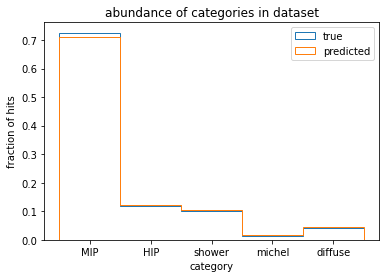

In [9]:
plt.hist(pred.query('sem_label>=0')['sem_label'],weights=NormOne(pred.query('sem_label>=0')['sem_label']),bins=np.linspace(0,5,6),histtype='step',label='true')
plt.hist(pred.query('sem_label>=0')['sem_pred'] ,weights=NormOne(pred.query('sem_label>=0')['sem_pred']),bins=np.linspace(0,5,6),histtype='step',label='predicted')
plt.xlabel('category')
plt.ylabel('fraction of hits')
plt.title('abundance of categories in dataset')
plt.xticks([0.5,1.5,2.5,3.5,4.5],classes)
plt.legend()
plt.show()

## Study network confidence in prediction

Here we use as a confidence score the softmax of the original scores, so that we get an estimate for the probability of the prediction.

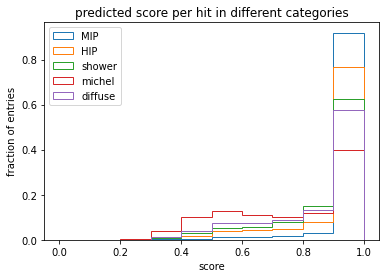

In [10]:
for i,ctg in enumerate(classes):
    x=pred.query('sem_label>=0 and sem_pred==%i'%i)['pred_score_p']
    plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step',label=ctg)
plt.legend(loc=2)
plt.xlabel('score')
plt.ylabel('fraction of entries')
plt.title('predicted score per hit in different categories')
plt.show()

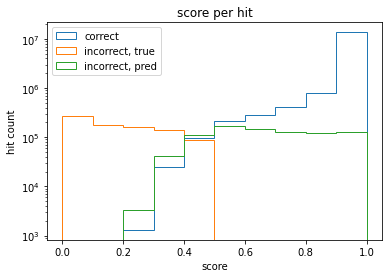

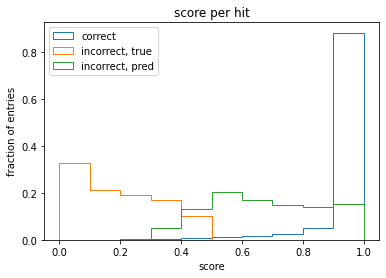

In [11]:
x=pred.query('sem_label>=0 and isgood==1')['true_score_p']
plt.hist(x,bins=np.linspace(0,1,11),histtype='step',label='correct')
x=pred.query('sem_label>=0 and isgood==0')['true_score_p']
plt.hist(x,bins=np.linspace(0,1,11),histtype='step',label='incorrect, true')
x=pred.query('sem_label>=0 and isgood==0')['pred_score_p']
plt.hist(x,bins=np.linspace(0,1,11),histtype='step',label='incorrect, pred')
plt.xlabel('score')
plt.ylabel('hit count')
plt.yscale('log')
plt.legend(loc=2)
plt.title('score per hit')
plt.show()

x=pred.query('sem_label>=0 and isgood==1')['true_score_p']
plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step',label='correct')
x=pred.query('sem_label>=0 and isgood==0')['true_score_p']
plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step',label='incorrect, true')
x=pred.query('sem_label>=0 and isgood==0')['pred_score_p']
plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step',label='incorrect, pred')
plt.xlabel('score')
plt.ylabel('fraction of entries')
plt.legend(loc=2)
plt.title('score per hit')
plt.show()

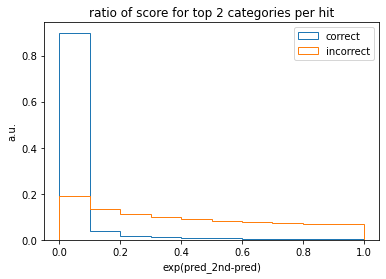

In [12]:
x=pred.query('sem_label>=0 and isgood==1').eval('exp(pred_score_2nd-pred_score)')
plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step',label='correct')
x=pred.query('sem_label>=0 and isgood==0').eval('exp(pred_score_2nd-pred_score)')
plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step',label='incorrect')
plt.xlabel('exp(pred_2nd-pred)')
plt.ylabel('a.u.')
plt.legend(loc=1)
plt.title('ratio of score for top 2 categories per hit')
plt.show()

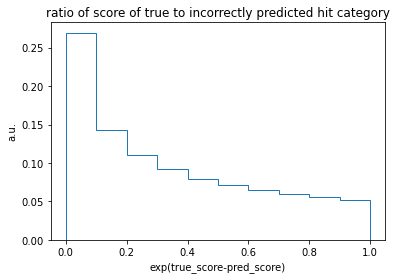

In [13]:
x=pred.query('sem_label>=0 and isgood==0').eval('exp(true_score-pred_score)')
plt.hist(x,weights=NormOne(x),bins=np.linspace(0,1,11),histtype='step')
plt.xlabel('exp(true_score-pred_score)')
plt.ylabel('a.u.')
plt.title('ratio of score of true to incorrectly predicted hit category')
plt.show()

In [ ]:
fpr, tpr, _ = metrics.roc_curve(pred.query('sem_label>=0')['isgood'], pred.query('sem_label>=0')['pred_score_p'])
plt.plot(fpr,tpr,label='all')
for c in [0,1,2,3,4]:
    fpr, tpr, _ = metrics.roc_curve(pred.query('sem_label==%i'%c)['isgood'], pred.query('sem_label==%i'%c)['pred_score_p'])
    plt.plot(fpr,tpr,label=classes[c])
    
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curves as a function of score probability')
plt.legend(loc=7)
plt.show()

## Confusion matrix by hit

In [ ]:
x = np.histogram2d(pred.query('sem_label>=0')['sem_pred'],pred.query('sem_label>=0')['sem_label'],bins=[np.linspace(0,5,6),np.linspace(0,5,6)])

eff = (x[0].transpose() / x[0].sum(axis=1)).transpose()
pur = x[0] / x[0].sum(axis=0)

fig = plt.figure(figsize=(7, 6))
plt.imshow(eff,origin='lower',cmap='copper')
for i in range(len(eff[0])):
    for j in range(len(eff[0])):
        text = plt.text(j, i, "%.2f"%eff[i, j],ha="center", va="center", color="w")
plt.colorbar()
plt.xlabel("assigned label")
ax = plt.gca()
ax.set_xticklabels(['','MIP','HIP','SHR','MCL','DFS'])
ax.set_yticklabels(['','MIP','HIP','SHR','MCL','DFS'])
plt.ylabel("true label")
plt.title('efficiency (by hit)')
plt.tight_layout()
fig.show()

fig = plt.figure(figsize=(7, 6))
plt.imshow(pur,origin='lower',cmap='copper')
for i in range(len(pur[0])):
    for j in range(len(pur[0])):
        text = plt.text(j, i, "%.2f"%pur[i, j],ha="center", va="center", color="w")
plt.colorbar()
plt.xlabel("assigned label")
ax = plt.gca()
ax.set_xticklabels(['','MIP','HIP','SHR','MCL','DFS'])
ax.set_yticklabels(['','MIP','HIP','SHR','MCL','DFS'])
plt.ylabel("true label")
plt.title('purity (by hit)')
plt.tight_layout()
fig.show()


In [ ]:
print('overall accuracy=',pred.query('sem_label>=0')['isgood'].sum()/pred.query('sem_label>=0')['isgood'].count())